In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
# parameters

t_max = 180             # シミュレーション日数
dt    = 0.01
pop   = 1000000         # シミュレーション人口（100万人）
b     = 1               # ルーズなb
m     = 0.04            # E→S
g     = 0.2 - m         # E -> I 1/incubtation
dh    = 0.007           # mortality in confirmed case（7%）/infectious period（10日）
rh    = 0.093           # d_i + r_i = Constant(1/infectious period（10日）) 
do    = 0.010           # mortality in unconfirmed case（4%）/infectious period（10日）
ro    = 0.090           # d_o + r_o = Constant(1/infectious period（10日）)

#初期状態

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

In [3]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [4]:
def tSEIRD(v, t, a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap):
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [5]:
def tSEIRD_matrix(Se,Sp,n,p,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [6]:
def tSEIRD_max(Se,Sp,n,p,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Positive']),np.max(df_['Hospitalised']),np.max(df_['Dead'])]

# cap=0.1,a=0.01

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


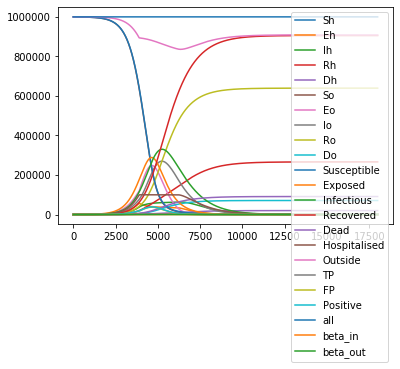

In [7]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.01).plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


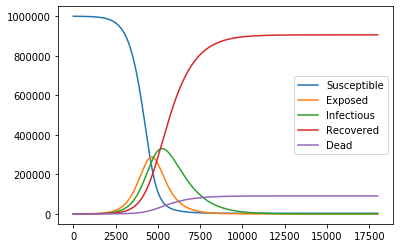

In [8]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.01)[['Susceptible','Exposed','Infectious','Recovered','Dead']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can a

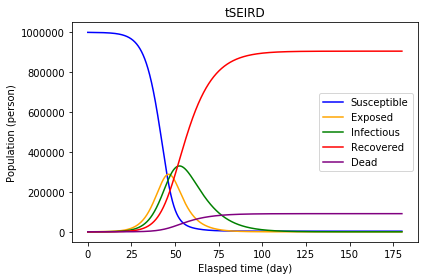

In [9]:
fig, ax = plt.subplots()
ax.set_title('tSEIRD')  

t = np.arange(0, t_max, dt)

y1 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.01)[['Susceptible']]
c1 = 'blue'
l1 = 'Susceptible'
ax.plot(t, y1, color=c1, label=l1)

y2 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.01)[['Exposed']]
c2 = 'orange'
l2 = 'Exposed'
ax.plot(t, y2, color=c2, label=l2)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.01)[['Infectious']]
c3 = 'green'
l3 = 'Infectious'
ax.plot(t, y3, color=c3, label=l3)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.01)[['Recovered']]
c3 = 'red'
l3 = 'Recovered'
ax.plot(t, y3, color=c3, label=l3)

y3 = tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.01)[['Dead']]
c3 = 'purple'
l3 = 'Dead'
ax.plot(t, y3, color=c3, label=l3)

ax.set_xlabel('Elasped time (day)')
ax.set_ylabel('Population (person)')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_sup1_C.png', dpi=300, bbox_inches='tight')
ax.legend(loc=0)
fig.tight_layout()

plt.show()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


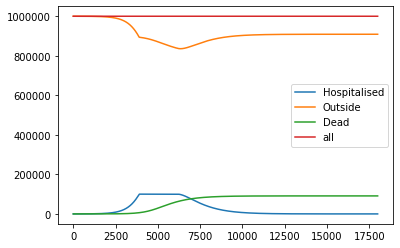

In [10]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.01)[['Hospitalised','Outside','Dead','all']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


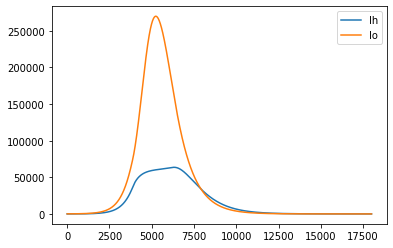

In [11]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.01)[['Ih','Io']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


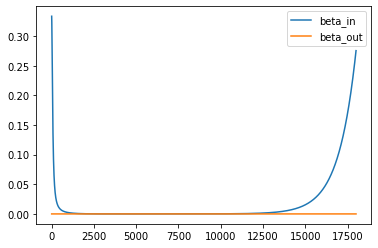

In [12]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.01)[['beta_in','beta_out']].plot()

In [13]:
tSEIRD_max(0.7,0.7,0.5,0.01,0.1,0.01)

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


[38747.21785165314, 100001.76027710584, 91094.1311934314]

In [14]:
v_a = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v_a = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_a.append(tSEIRD_max(0.7,0.7,i,j,0.1,0.01))

pos_test_fix_a   = np.array(v_a)[:, 0].reshape((101, 101))
hosp_test_fix_a  = np.array(v_a)[:, 1].reshape((101, 101))
death_test_fix_a = np.array(v_a)[:, 2].reshape((101, 101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


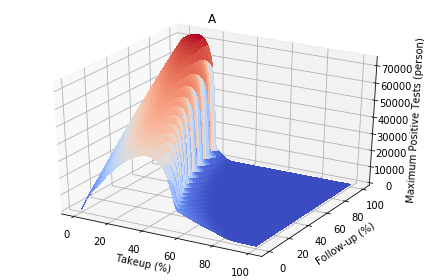

In [15]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_test_fix_a #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_test_fix_a), np.max(pos_test_fix_a)))
#ax.set_zlim((np.min(positive_test_fix)/1000, np.max(positive_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

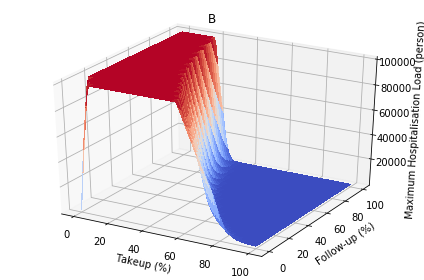

In [16]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_test_fix_a#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_test_fix_a),np.max(hosp_test_fix_a)))
#ax.set_zlim((np.min(hospitalised_test_fix)/1000,np.max(hospitalised_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

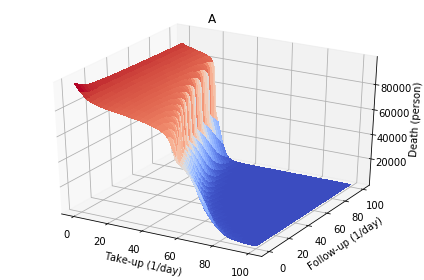

In [79]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_a#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_test_fix_a), np.max(death_test_fix_a)))
#ax.set_zlim((np.min(death_test_fix)/1000, np.max(death_test_fix)/1000))

ax.set_xlabel('Take-up (1/day)')
ax.set_ylabel('Follow-up (1/day)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 受診率を固定してsurfaceplot

In [18]:
# 受診率固定して検査特性変えた場合の最大入院者数、死者数、陽性者数

t_a = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        t_a.append(tSEIRD_max(i,j,0.5,0.5,0.1,0.01))

pos_visit_fix_a   = np.array(t_a)[:, 0].reshape((101, 101))
hosp_visit_fix_a  = np.array(t_a)[:, 1].reshape((101, 101))
death_visit_fix_a = np.array(t_a)[:, 2].reshape((101, 101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


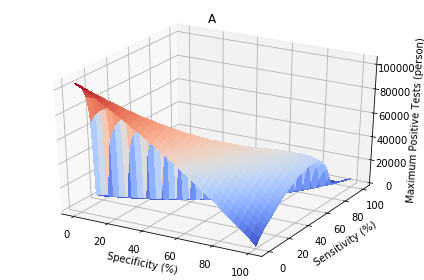

In [19]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_visit_fix_a #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_visit_fix_a), np.max(pos_visit_fix_a)))
#ax.set_zlim((np.min(positive_visitfix)/1000, np.max(positive_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

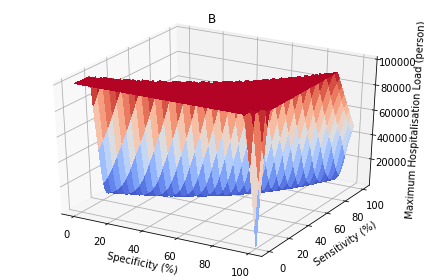

In [20]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_visit_fix_a#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_visit_fix_a),np.max(hosp_visit_fix_a)))
#ax.set_zlim((np.min(hospitalised_visit_fix_)/1000,np.max(hospitalised_visit_fix_)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

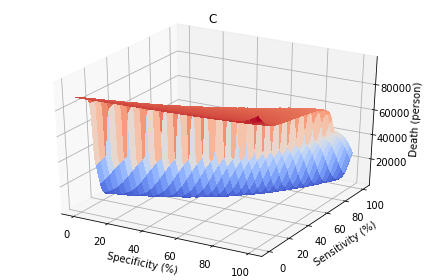

In [21]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_visit_fix_a#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_visit_fix_a), np.max(death_visit_fix_a)))
#ax.set_zlim((np.min(death_visit_fix)/1000, np.max(death_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# cap=0.1,a=0.03

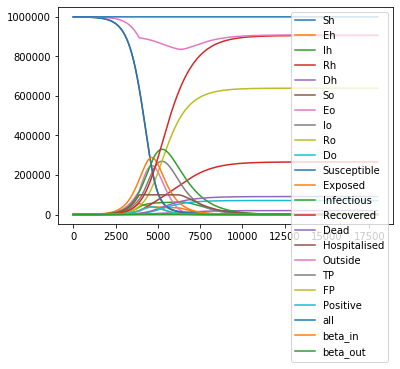

In [22]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.03).plot()

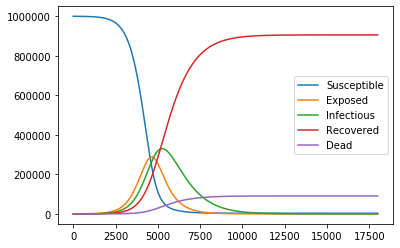

In [23]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.03)[['Susceptible','Exposed','Infectious','Recovered','Dead']].plot()

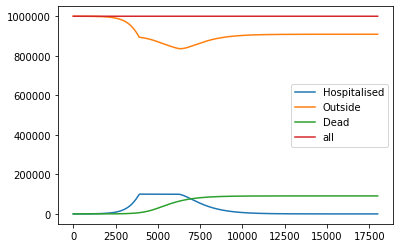

In [24]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.03)[['Hospitalised','Outside','Dead','all']].plot()

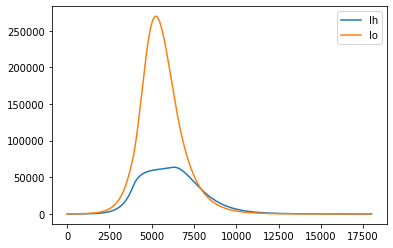

In [25]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.03)[['Ih','Io']].plot()

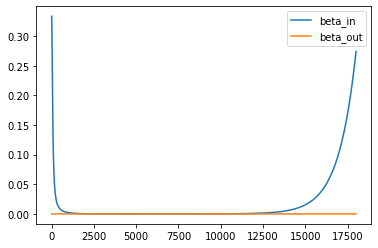

In [26]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.03)[['beta_in','beta_out']].plot()

In [27]:
tSEIRD_max(0.7,0.7,0.5,0.01,0.1,0.03)

[38712.24235475925, 100001.74504435573, 91077.14005626959]

In [28]:
v_b = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v_b = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_b.append(tSEIRD_max(0.7,0.7,i,j,0.1,0.03))

pos_test_fix_b   = np.array(v_b)[:, 0].reshape((101, 101))
hosp_test_fix_b  = np.array(v_b)[:, 1].reshape((101, 101))
death_test_fix_b = np.array(v_b)[:, 2].reshape((101, 101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


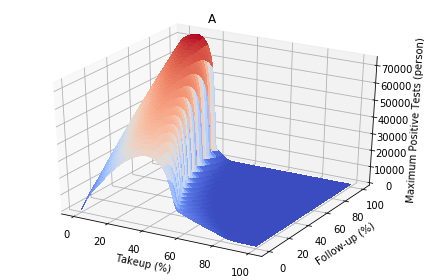

In [29]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_test_fix_b #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_test_fix_b), np.max(pos_test_fix_b)))
#ax.set_zlim((np.min(positive_test_fix)/1000, np.max(positive_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

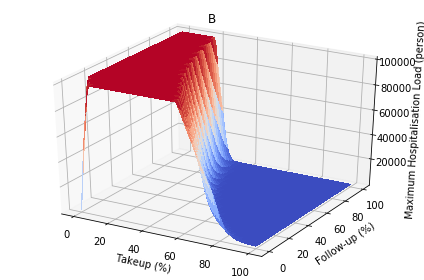

In [30]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_test_fix_b#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_test_fix_b),np.max(hosp_test_fix_b)))
#ax.set_zlim((np.min(hospitalised_test_fix)/1000,np.max(hospitalised_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

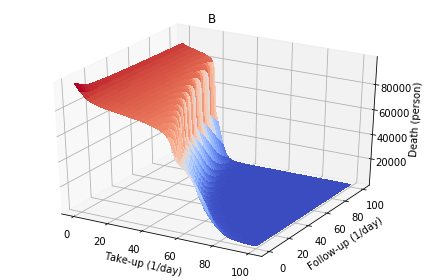

In [80]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_b#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_test_fix_b), np.max(death_test_fix_b)))
#ax.set_zlim((np.min(death_test_fix)/1000, np.max(death_test_fix)/1000))

ax.set_xlabel('Take-up (1/day)')
ax.set_ylabel('Follow-up (1/day)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 受診率を固定してsurfaceplot

In [32]:
# 受診率固定して検査特性変えた場合の最大入院者数、死者数、陽性者数

t_b = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        t_b.append(tSEIRD_max(i,j,0.5,0.5,0.1,0.03))

pos_visit_fix_b   = np.array(t_b)[:, 0].reshape((101, 101))
hosp_visit_fix_b  = np.array(t_b)[:, 1].reshape((101, 101))
death_visit_fix_b = np.array(t_b)[:, 2].reshape((101, 101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


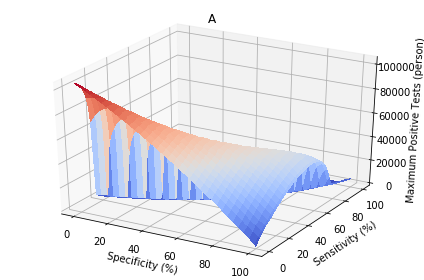

In [33]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_visit_fix_b #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_visit_fix_b), np.max(pos_visit_fix_b)))
#ax.set_zlim((np.min(positive_visitfix)/1000, np.max(positive_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

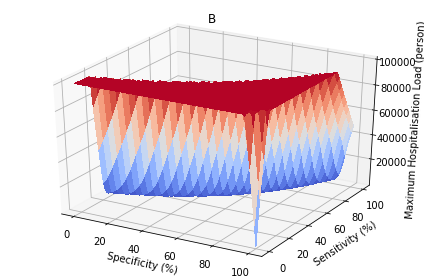

In [34]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_visit_fix_b#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_visit_fix_b),np.max(hosp_visit_fix_b)))
#ax.set_zlim((np.min(hospitalised_visit_fix_)/1000,np.max(hospitalised_visit_fix_)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

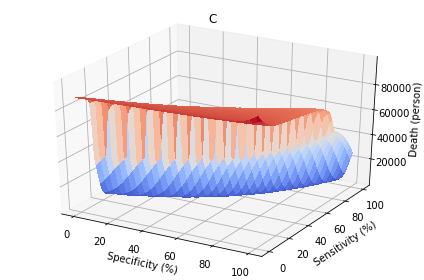

In [35]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_visit_fix_b#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_visit_fix_b), np.max(death_visit_fix_b)))
#ax.set_zlim((np.min(death_visit_fix)/1000, np.max(death_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# cap=0.1,a=0.1

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


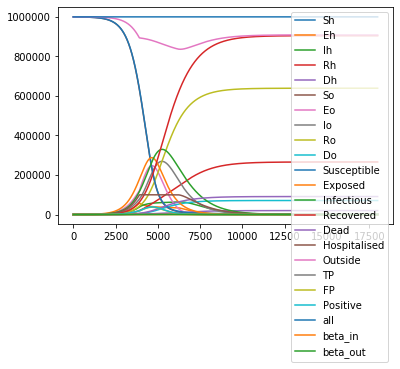

In [36]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.1).plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


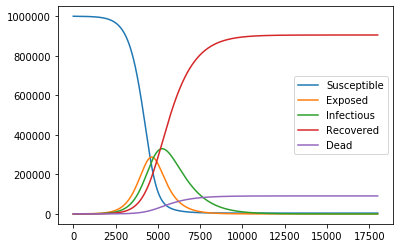

In [37]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.1)[['Susceptible','Exposed','Infectious','Recovered','Dead']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


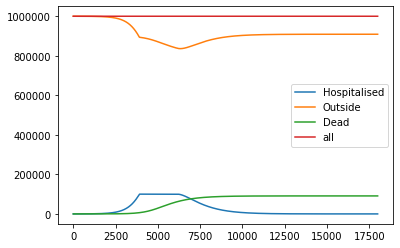

In [38]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.1)[['Hospitalised','Outside','Dead','all']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


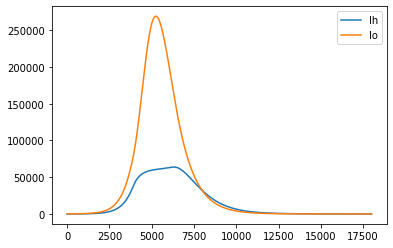

In [39]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.1)[['Ih','Io']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


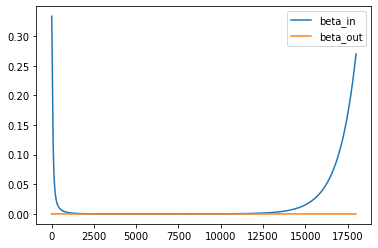

In [40]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.1)[['beta_in','beta_out']].plot()

In [41]:
tSEIRD_max(0.7,0.7,0.5,0.01,0.1,0.1)

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


[38609.24347302285, 100001.70119894476, 91026.77039049531]

In [42]:
v_c = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v_c = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_c.append(tSEIRD_max(0.7,0.7,i,j,0.1,0.1))

pos_test_fix_c   = np.array(v_c)[:, 0].reshape((101, 101))
hosp_test_fix_c  = np.array(v_c)[:, 1].reshape((101, 101))
death_test_fix_c = np.array(v_c)[:, 2].reshape((101, 101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


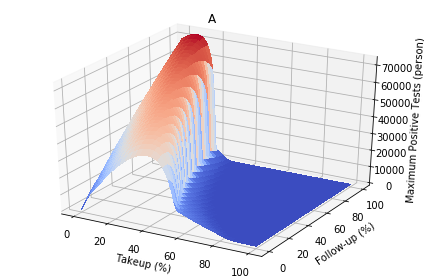

In [43]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_test_fix_c #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_test_fix_c), np.max(pos_test_fix_c)))
#ax.set_zlim((np.min(positive_test_fix)/1000, np.max(positive_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

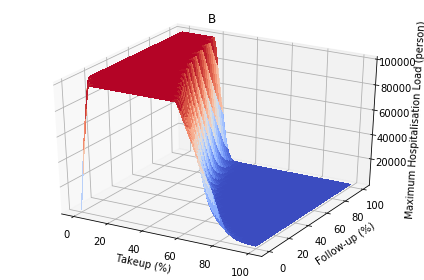

In [44]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_test_fix_c#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_test_fix_c),np.max(hosp_test_fix_c)))
#ax.set_zlim((np.min(hospitalised_test_fix)/1000,np.max(hospitalised_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

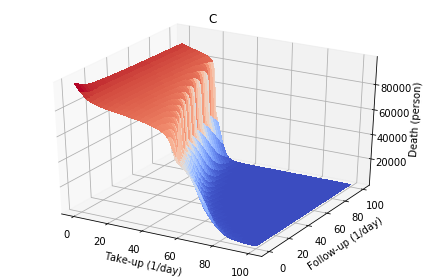

In [81]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_c#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_test_fix_c), np.max(death_test_fix_c)))
#ax.set_zlim((np.min(death_test_fix)/1000, np.max(death_test_fix)/1000))

ax.set_xlabel('Take-up (1/day)')
ax.set_ylabel('Follow-up (1/day)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 受診率を固定してsurfaceplot

In [46]:
# 受診率固定して検査特性変えた場合の最大入院者数、死者数、陽性者数

t_c = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        t_c.append(tSEIRD_max(i,j,0.5,0.5,0.1,0.1))

pos_visit_fix_c   = np.array(t_c)[:, 0].reshape((101, 101))
hosp_visit_fix_c  = np.array(t_c)[:, 1].reshape((101, 101))
death_visit_fix_c = np.array(t_c)[:, 2].reshape((101, 101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


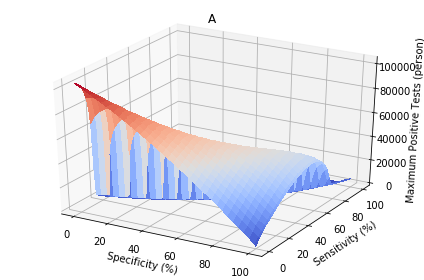

In [47]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_visit_fix_c #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_visit_fix_c), np.max(pos_visit_fix_c)))
#ax.set_zlim((np.min(positive_visitfix)/1000, np.max(positive_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

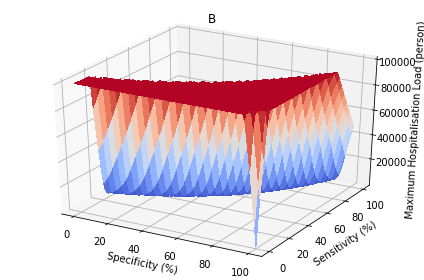

In [48]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_visit_fix_c#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_visit_fix_c),np.max(hosp_visit_fix_c)))
#ax.set_zlim((np.min(hospitalised_visit_fix_)/1000,np.max(hospitalised_visit_fix_)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

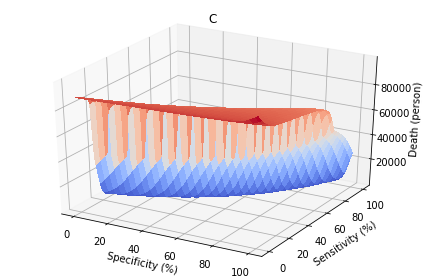

In [49]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_visit_fix_c#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_visit_fix_c), np.max(death_visit_fix_c)))
#ax.set_zlim((np.min(death_visit_fix)/1000, np.max(death_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# cap=0.1,a=0.3

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


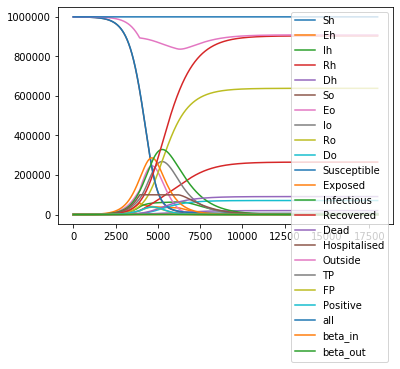

In [50]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.3).plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


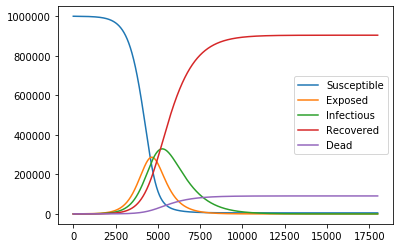

In [51]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.3)[['Susceptible','Exposed','Infectious','Recovered','Dead']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


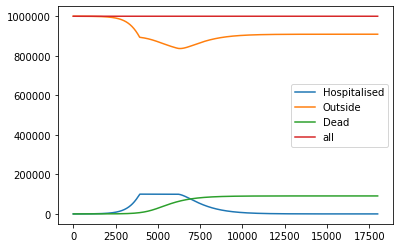

In [52]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.3)[['Hospitalised','Outside','Dead','all']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


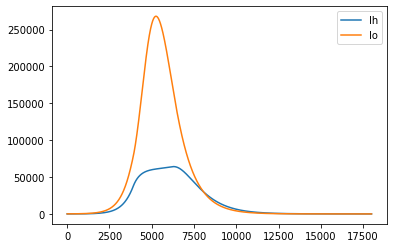

In [53]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.3)[['Ih','Io']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


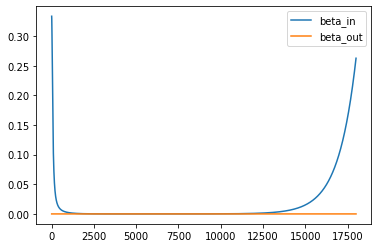

In [54]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,0.3)[['beta_in','beta_out']].plot()

In [55]:
tSEIRD_max(0.7,0.7,0.5,0.01,0.1,0.3)

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


[38417.91366715463, 100001.62225788312, 90931.77271932746]

In [56]:
v_d = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v_d = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_d.append(tSEIRD_max(0.7,0.7,i,j,0.1,0.3))

pos_test_fix_d   = np.array(v_d)[:, 0].reshape((101, 101))
hosp_test_fix_d  = np.array(v_d)[:, 1].reshape((101, 101))
death_test_fix_d = np.array(v_d)[:, 2].reshape((101, 101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


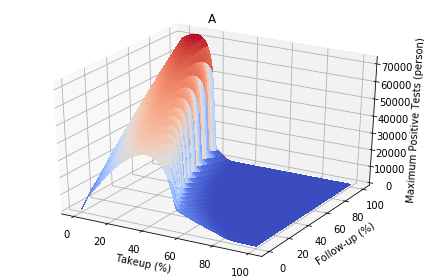

In [57]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_test_fix_d #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_test_fix_d), np.max(pos_test_fix_d)))
#ax.set_zlim((np.min(positive_test_fix)/1000, np.max(positive_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

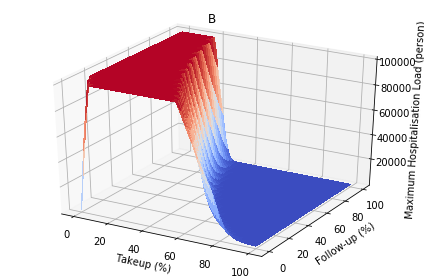

In [58]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_test_fix_d#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_test_fix_d),np.max(hosp_test_fix_d)))
#ax.set_zlim((np.min(hospitalised_test_fix)/1000,np.max(hospitalised_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

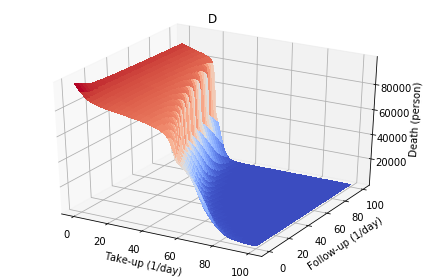

In [82]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_d#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_test_fix_d), np.max(death_test_fix_d)))
#ax.set_zlim((np.min(death_test_fix)/1000, np.max(death_test_fix)/1000))

ax.set_xlabel('Take-up (1/day)')
ax.set_ylabel('Follow-up (1/day)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('D')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 受診率を固定してsurfaceplot

In [60]:
# 受診率固定して検査特性変えた場合の最大入院者数、死者数、陽性者数

t_d = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        t_d.append(tSEIRD_max(i,j,0.5,0.5,0.1,0.3))

pos_visit_fix_d   = np.array(t_d)[:, 0].reshape((101, 101))
hosp_visit_fix_d  = np.array(t_d)[:, 1].reshape((101, 101))
death_visit_fix_d = np.array(t_d)[:, 2].reshape((101, 101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


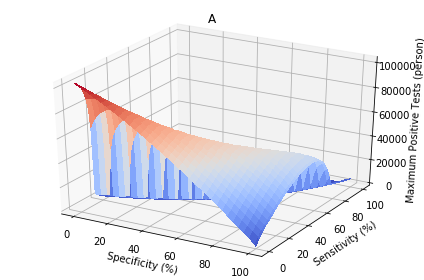

In [61]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_visit_fix_d #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_visit_fix_d), np.max(pos_visit_fix_d)))
#ax.set_zlim((np.min(positive_visitfix)/1000, np.max(positive_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

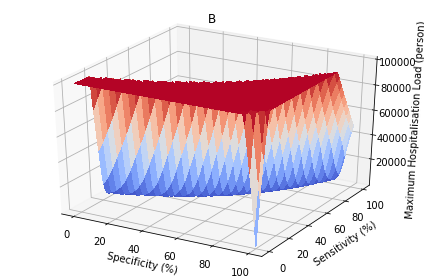

In [62]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_visit_fix_d#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_visit_fix_d),np.max(hosp_visit_fix_d)))
#ax.set_zlim((np.min(hospitalised_visit_fix_)/1000,np.max(hospitalised_visit_fix_)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

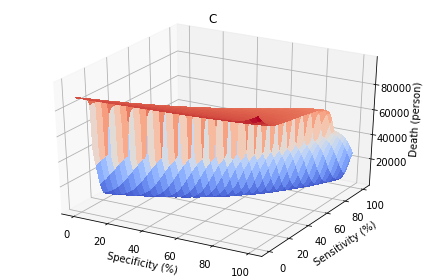

In [63]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_visit_fix_d#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_visit_fix_d), np.max(death_visit_fix_d)))
#ax.set_zlim((np.min(death_visit_fix)/1000, np.max(death_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# cap=0.1,a=1

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


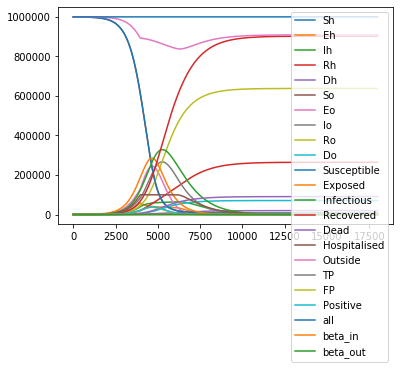

In [64]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,1).plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


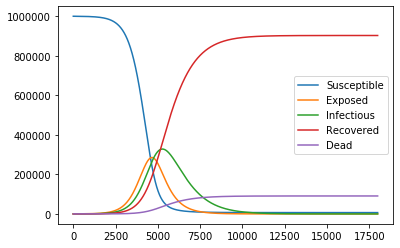

In [65]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,1)[['Susceptible','Exposed','Infectious','Recovered','Dead']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


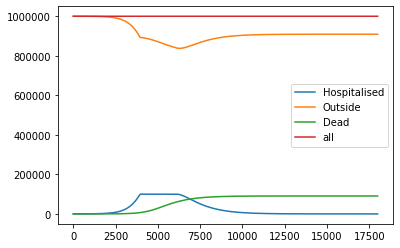

In [66]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,1)[['Hospitalised','Outside','Dead','all']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


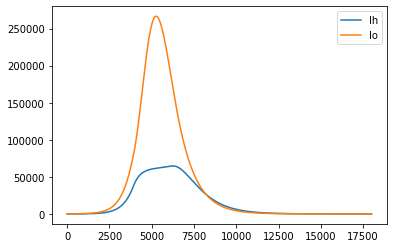

In [67]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,1)[['Ih','Io']].plot()

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


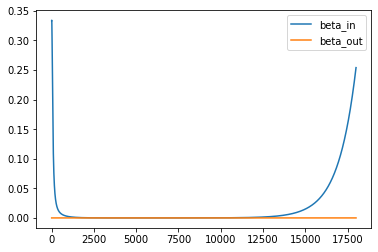

In [68]:
tSEIRD_matrix(0.7,0.7,0.5,0.01,0.1,1)[['beta_in','beta_out']].plot()

In [69]:
tSEIRD_max(0.7,0.7,0.5,0.01,0.1,1)

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


[38155.127656081226, 100001.51630144822, 90797.87346631337]

In [70]:
v_e = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v_e = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_e.append(tSEIRD_max(0.7,0.7,i,j,0.1,1))

pos_test_fix_e   = np.array(v_e)[:, 0].reshape((101, 101))
hosp_test_fix_e  = np.array(v_e)[:, 1].reshape((101, 101))
death_test_fix_e = np.array(v_e)[:, 2].reshape((101, 101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


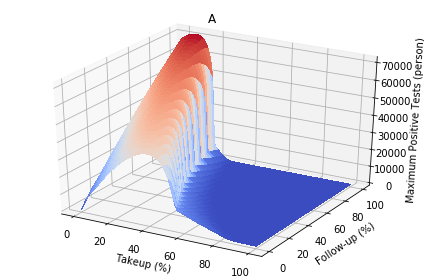

In [71]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_test_fix_e #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_test_fix_e), np.max(pos_test_fix_e)))
#ax.set_zlim((np.min(positive_test_fix)/1000, np.max(positive_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

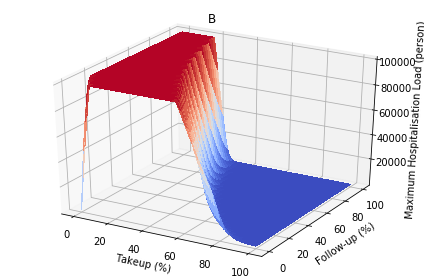

In [72]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_test_fix_e#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_test_fix_e),np.max(hosp_test_fix_e)))
#ax.set_zlim((np.min(hospitalised_test_fix)/1000,np.max(hospitalised_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

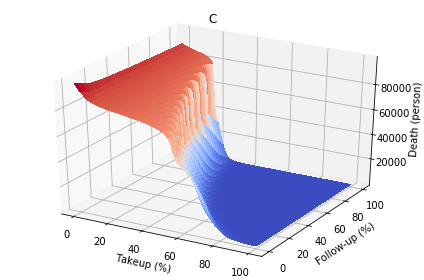

In [73]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_e#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_test_fix_e), np.max(death_test_fix_e)))
#ax.set_zlim((np.min(death_test_fix)/1000, np.max(death_test_fix)/1000))

ax.set_xlabel('Takeup (%)')
ax.set_ylabel('Follow-up (%)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 受診率を固定してsurfaceplot

In [74]:
# 受診率固定して検査特性変えた場合の最大入院者数、死者数、陽性者数

t_e = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        t_e.append(tSEIRD_max(i,j,0.5,0.5,0.1,1))

pos_visit_fix_e   = np.array(t_e)[:, 0].reshape((101, 101))
hosp_visit_fix_e  = np.array(t_e)[:, 1].reshape((101, 101))
death_visit_fix_e = np.array(t_e)[:, 2].reshape((101, 101))

C:\Users\bougt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


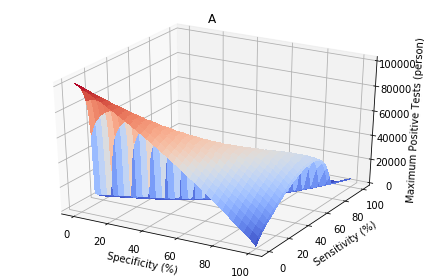

In [75]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = pos_visit_fix_e #/ 1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(pos_visit_fix_e), np.max(pos_visit_fix_e)))
#ax.set_zlim((np.min(positive_visitfix)/1000, np.max(positive_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Positive Tests (person)')#' (1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3A.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

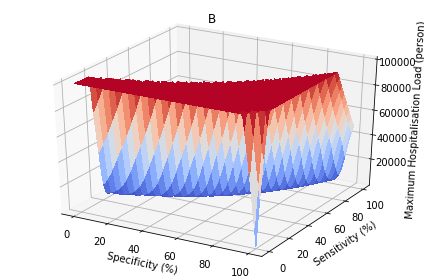

In [76]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = hosp_visit_fix_e#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(hosp_visit_fix_e),np.max(hosp_visit_fix_e)))
#ax.set_zlim((np.min(hospitalised_visit_fix_)/1000,np.max(hospitalised_visit_fix_)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Maximum Hospitalisation Load (person)')#' (1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3B.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

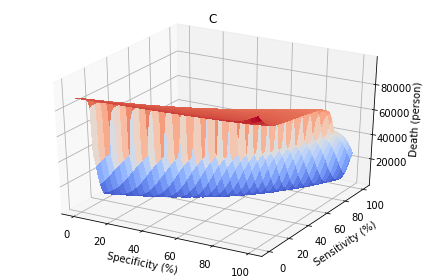

In [77]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_visit_fix_e#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim((np.min(death_visit_fix_e), np.max(death_visit_fix_e)))
#ax.set_zlim((np.min(death_visit_fix)/1000, np.max(death_visit_fix)/1000))

ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
ax.set_zlabel('Death (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [83]:
from email import message
import smtplib
 

smtp_host = 'smtp.gmail.com'   # メールを送るSMTPサーバー
smtp_port = 587   # ポート番号
from_email = 'bougtoir@gmail.com'   # 送信元のメールアドレス(Gmeilアドレス)
to_email = 'bougtoir@gmail.com'   # 送信先のメールアドレス
username = 'bougtoir@gmail.com'   # ユーザーネームはGoogleアカウント（Gmailアドレス）
password = 'asalxwpzjstooggg'   # Googleアカウントのパスワード
 
# 送信メールを作成する
msg = message.EmailMessage()   # メッセージオブジェクトを作成
msg.set_content('本当に結果出たよ！')   # メール本文
msg['Subject'] = 'note from python'   # メールのタイトル（件名）
msg['From'] = from_email   # メール送信元
msg['To'] = to_email   # メール送信先
 
# メールサーバーへアクセスする
server = smtplib.SMTP(smtp_host, smtp_port)
server.ehlo()
server.starttls()
server.ehlo()
server.login(username, password)
server.send_message(msg)
server.quit()

(221, b'2.0.0 closing connection d16sm8181671pjd.25 - gsmtp')